## Step 1: Problem Definition

### Objective
Build a deep learning prototype model to classify fundus images into four categories:  
- **Cataract**  
- **Diabetic Retinopathy**  
- **Glaucoma**  
- **Normal (Healthy)**  

This model operates without a metadata CSV, relying solely on image data for classification.

### Disclaimer
This is a **prototype research model** intended for academic and technical exploration.  
**It is not a diagnostic tool and should not be used for clinical decision-making.**

### Motivation
Early detection of eye diseases is crucial to prevent vision loss. Automating classification from fundus images can:
- Support screening in resource-limited settings  
- Assist medical professionals with faster assessments  
- Lay groundwork for future clinical decision-support systems

### Problem Statement
Design a deep learning pipeline that ingests raw fundus images and outputs one of four disease classes with high accuracy and interpretability—without using external metadata.

### Class Definitions
- **Cataract**: Clouding of the eye’s natural lens, causing vision impairment. Fundus images show opacities or discoloration in the lens.
- **Diabetic Retinopathy (DR)**: Damage to retinal blood vessels due to diabetes, with signs like microaneurysms, hemorrhages, and exudates in fundus images.
- **Glaucoma**: A group of diseases damaging the optic nerve, often caused by high intraocular pressure. Fundus images show optic nerve cupping and nerve fiber loss.
- **Normal (Healthy)**: No visible disease signs in the fundus. The retina and optic nerve appear healthy, with clear vessels and a normal optic disc.

### Assumptions and Constraints
- **Well-defined classes**: Each class (Cataract, Glaucoma, DR, Normal) has clear clinical definitions to ensure accurate labeling and learning.
- Only image data is used—no patient metadata or clinical history.
- The model is a prototype, with real-world deployment considered for future steps.


<h2>Importing Necessary Libraries</h2>

In [1]:
import tensorflow as tf
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
import os
import random
from PIL import Image, UnidentifiedImageError
import seaborn as sns
from tensorflow import keras
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Activation, Flatten, Dense, GlobalAveragePooling2D, MaxPooling2D, Dropout, BatchNormalization
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet import preprocess_input
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from keras.models import load_model
from keras.optimizers import Adam
from keras.models import Sequential
from keras.metrics import AUC
from PIL import Image
import numpy as np
import warnings
import cv2

warnings.filterwarnings('ignore')

<h2>Step 2: Data Quality Assessment</h2>

In [2]:
#---------------------------Base Directory-------------------------------------------------
BASE_DIR = Path('split')

train_dir = BASE_DIR / "train"
val_dir   = BASE_DIR / "val"
test_dir  = BASE_DIR / "test"

# 3. Verify that these are Paths and exist
print(type(BASE_DIR), BASE_DIR.exists())
print(type(train_dir), train_dir.exists())
print(type(val_dir), val_dir.exists())
print(type(test_dir), test_dir.exists())

<class 'pathlib.WindowsPath'> True
<class 'pathlib.WindowsPath'> True
<class 'pathlib.WindowsPath'> True
<class 'pathlib.WindowsPath'> True


In [3]:
#---------------Inspecting the Class Names inside the directories------------------------
def label_Inspection(directory_path):
    return os.listdir(directory_path)

# Function Call
train_Labels = label_Inspection(train_dir)
test_Labels = label_Inspection(test_dir)
val_Labels = label_Inspection(val_dir)

print(f'Train Labels: {train_Labels}')
print(f'Test Labels: {test_Labels}')
print(f'Validation Labels: {val_Labels}')


Train Labels: ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']
Test Labels: ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']
Validation Labels: ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']


In [4]:
def Images_Per_Directory(directory_path):
    image_paths = []
    for class_name in os.listdir(directory_path):
        class_dir = os.path.join(directory_path, class_name)
        if not os.path.isdir(class_dir):
            continue
        for file_name in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file_name)
            image_paths.append(file_path)
    
    print(f"Total images in '{directory_path}': {len(image_paths)}")
    return image_paths


train_images = Images_Per_Directory(train_dir)
test_images = Images_Per_Directory(test_dir)
val_images = Images_Per_Directory(val_dir)


Total images in 'split\train': 2939
Total images in 'split\test': 425
Total images in 'split\val': 837


<h3> 2.2 Image Structure and Integrity Check </h3>
<ul><li><u> Sample Level Visual Inspection </u></li></ul>

In [5]:
BASE_DIR = Path('split')
def list_classes(directory: Path):
    return sorted([p.name for p in directory.iterdir() if p.is_dir()])

# 3. Dynamically build the full list of class-folder paths
Folders = []   # make sure this name matches what you'll print
for split in ("train", "val", "test"):
    split_dir = BASE_DIR / split
    for cls in list_classes(split_dir):
        Folders.append(split_dir / cls)

# 4. Inspect result
print("Found class folders:")
for folder in Folders:
    print(" ", folder)



Found class folders:
  split\train\cataract
  split\train\diabetic_retinopathy
  split\train\glaucoma
  split\train\normal
  split\val\cataract
  split\val\diabetic_retinopathy
  split\val\glaucoma
  split\val\normal
  split\test\cataract
  split\test\diabetic_retinopathy
  split\test\glaucoma
  split\test\normal


In [6]:
Folders[0]

WindowsPath('split/train/cataract')

In [7]:
# Accessing the Sample Image Names for Sample Inspection

def sampleImageNames(folderpath):
    Names = os.listdir(folderpath)[-6:-1]
    sampleNames = []
    for x in Names:
        x = folderpath+'/'+x
        sampleNames.append(x)
    print(sampleNames)

sampleImageNames(str(Folders[0]))

['split\\train\\cataract/_94_5517058.jpg', 'split\\train\\cataract/_96_5515894.jpg', 'split\\train\\cataract/_96_6290965.jpg', 'split\\train\\cataract/_97_6398110.jpg', 'split\\train\\cataract/_97_761368.jpg']


The Format of the Image is: JPEG
The Mode of the Image is: RGB
The Size of the Image is: (256, 256)


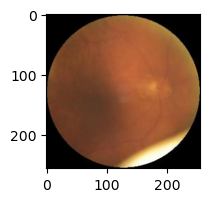

In [8]:
# Creating a function to inspect the Images and get overview through random sampling

def sampleImageInspection(imgpath):
    image = Image.open(imgpath)
    print(f'The Format of the Image is: {image.format}')
    print(f'The Mode of the Image is: {image.mode}')
    print(f'The Size of the Image is: {image.size}')
    plt.figure(figsize=(5,2))
    plt.imshow(image)
    plt.show()

# Function Call
sampleImageInspection('split\\train\\cataract/_94_5517058.jpg')
# Copied the Image Path from the above Function.

<ul><li><u> Batch Level Automated Scan </u></li></ul>

In [9]:
# Creating a Function that inspects all the images of all Folders

def batchImageInspection(allFolderNames):
    formats = set()
    modes = set()
    sizes = set()
    corrupt_files = []
    
    for specific_folder in allFolderNames: # Looping all the folders which contain images one after another
        for filename in os.listdir(specific_folder): # Accessing the FileName[image] of each folder
            try: 
                filepath = os.path.join(specific_folder, filename)# Joining FolderHierchy+Filename which makes the filepath that will help to create an Image array Object.
        
                image = Image.open(filepath) # Image Object Created
                formats.add(image.format) # Format of the Image jpg/jpeg/png
                modes.add(image.mode) # Mode of the image Color/GrayScale
                sizes.add(image.size) # Size of the image interms of Height and Width
            except (UnidentifiedImageError, OSError):
                corrupt_files.append(filepath)  # This Ensures that corrupt files and Unsupported File Formats have been properly identified.
                

    print(f'Formats Found: {formats}')
    print(f'Sizes Found: {sizes}')
    print(f'Modes Found: {modes}')
    if corrupt_files:
        print(f'There are {len(corrupt_files)} Corrupt that has files  been detected')
        print('===========CORRUPT FILE NAMES=======================')
        print(corrupt_files)
        return corrupt_files
    else:
        print('No Corrupt File has Been Found')

# BatchImage Inspection Function Call

batchImageInspection(Folders)

# If Corrupt Files Found
# Corrupt_Files = batchImageInspection(Folders)

Formats Found: {'PNG', 'JPEG'}
Sizes Found: {(512, 512), (2464, 1632), (2592, 1728), (1848, 1224), (256, 256)}
Modes Found: {'RGB'}
No Corrupt File has Been Found


In [10]:
# # Function to be used if the folders have images other than .ipynb checkpoints

def removeCorruptFiles(corrupt_files):
    for filepath in corrupt_files:
        try:
            os.remove(filepath)
            print(f"Removed: {filepath}")
        except Exception as e:
            print(f"Error removing {filepath}: {e}")

#removeCorruptFiles(Corrupt_Files)

<h2> <u> Image Clarity Inspection </u> </h2>

In [11]:
blur_threshold = 20  # Because Medical Images have Soft Gradients
# Change in intensity across the image is not sharp and abrupt.

def blur_Inspection(filepath):
    image = cv2.imread(filepath)
    if image is None:
        raise ValueError(f"Image not found or unreadable: {filepath}")
    image = cv2.resize(image, (224, 224))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    variance = cv2.Laplacian(gray, cv2.CV_64F).var()
    return variance, variance < blur_threshold


blur_Inspection('split\\train\\cataract/_94_5517058.jpg')

(219.11799214810742, False)

In [12]:
def batch_Blur_Inspection(all_FolderNames):
    blur_images = []
    for specific_folder in all_FolderNames:
        for file_name in os.listdir(specific_folder):
            if not file_name.lower().endswith(('.png', '.jpg', '.jpeg')):  # skip non-image files
                continue
            filepath = os.path.join(specific_folder, file_name)
            try:
                Blur_Score, IMAGE_IS_BLUR = blur_Inspection(filepath)
                if IMAGE_IS_BLUR:
                    blur_images.append((filepath))
    
            except Exception as e:
                print(f'{e}')
    
    if blur_images:
        print(f'There are {len(blur_images)} blur images')
        return blur_images
    else:
        print('No blur images found')


batch_Blur_Inspection(Folders)

No blur images found


## Class Balance Check ##

<Figure size 640x480 with 0 Axes>

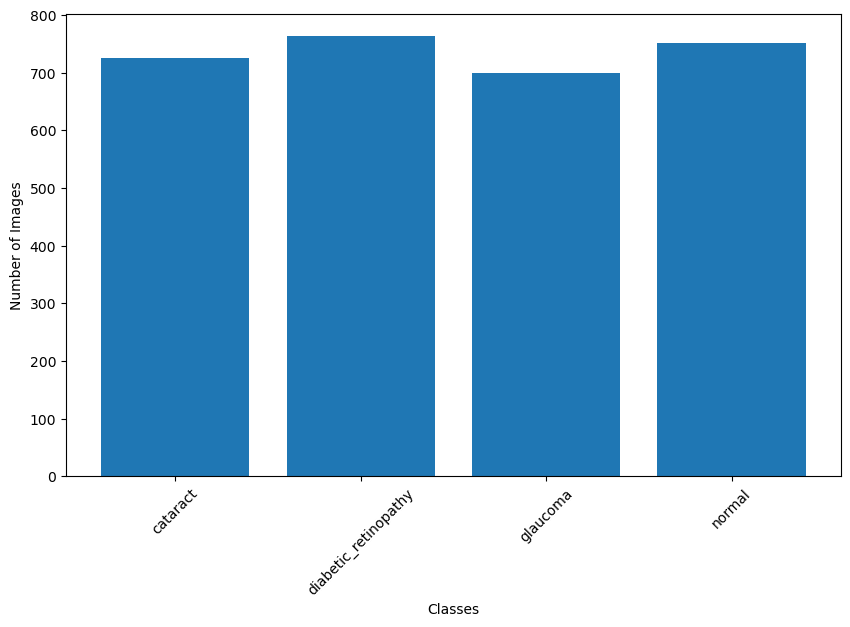

[('cataract', 726), ('diabetic_retinopathy', 763), ('glaucoma', 699), ('normal', 751)]


In [13]:
import os
import matplotlib.pyplot as plt

liste = []
for classes in os.listdir(train_dir):
    specific_folder_paths = os.path.join(train_dir, classes)
    liste.append((classes, len
                  (os.listdir(specific_folder_paths))))

# Extract class names and counts
class_names = [x[0] for x in liste]
counts = [x[1] for x in liste]

# Plotting the class distribution
#plt.title('Class Distribution Overview')
plt.suptitle('Class Distribution')
plt.figure(figsize=(10, 6))  # Adjust the size for better visibility
plt.bar(class_names, counts)  # Using a bar plot to visualize the distribution
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.show()
print(liste)


<br>
<b>As seen above, the class distribution is fairly balanced. Each class has a comparable number of samples, with no single class dominating the dataset. The difference between the smallest and largest class is less than 10%, which is within an acceptable range for multi-class classification.
<br>

# Step 3: Data Preprocessing #

<h3> Preprocessing </li> </ul> </h3>
<h5> <u> Resizing the Images </u> </h5>

In [14]:
# Preprocessing

train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.2,
                                   shear_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255)


# Accessing the Directories nad assigning batch level operations
training = train_datagen.flow_from_directory(directory=train_dir, target_size=(224,224), batch_size=32,
                                             class_mode='categorical')
testing = test_datagen.flow_from_directory(directory=test_dir, target_size=(224,224), batch_size=32,
                                             class_mode='categorical')
validation = val_datagen.flow_from_directory(directory=val_dir, target_size=(224,224), batch_size=32,
                                             class_mode='categorical')

Found 2939 images belonging to 4 classes.
Found 425 images belonging to 4 classes.
Found 837 images belonging to 4 classes.


# Baseline Model [CNN From Scratch] #

<b>To establish a reliable performance baseline, a custom Convolutional Neural Network (CNN) was built from scratch. The architecture is partially inspired by the VGG family of networks, which are known for their simplicity, deep convolutional stacks, and effective performance in image classification tasks.</b>

In [15]:
# Input Shape
input_tensor = Input(shape=(224,224,3))

# Adding the Convolutional layers

# First Convolutional layer
layer1 = Conv2D(filters=32, kernel_size=3, padding='same')
activation1 = Activation('relu')
conv_layer1 = layer1(input_tensor)
conv_layer1 = activation1(conv_layer1)
pooling_layer1 = MaxPooling2D(pool_size=(2,2), strides=2)
conv_layer1_pooled = pooling_layer1(conv_layer1)

# Second Convolutional layer
layer2 = Conv2D(filters=64, kernel_size=3, padding='same')
activation2 = Activation('relu')
conv_layer2 = layer2(conv_layer1_pooled)
conv_layer2 = activation2(conv_layer2)
pooling_layer2 = MaxPooling2D(pool_size=(2,2), strides=2)
conv_layer2_pooled = pooling_layer2(conv_layer2)

# Third Convolutional layer
layer3 = Conv2D(filters=256, kernel_size=3, padding='same')
activation3 = Activation('relu')
conv_layer3 = layer3(conv_layer2_pooled)
conv_layer3 = activation3(conv_layer3)
pooling_layer3 = MaxPooling2D(pool_size=(2,2), strides=2)
conv_layer3_pooled = pooling_layer3(conv_layer3)


# Flattening the Layers
# Global Average Pooling instead of Flatten
flatten_layer = GlobalAveragePooling2D()
conv_layers_flatten = flatten_layer(conv_layer3_pooled)


# Fully COnnected Leyers
dense1 = Dense(units=256, kernel_initializer='he_normal')
activation_dense1 = Activation('relu')
dense_layer1 = dense1(conv_layers_flatten)
dropout = Dropout(0.5)
dropout_layer = dropout(dense_layer1)
dense_layer1_activated = activation_dense1(dropout_layer)

# Output Layer
dense2 = Dense(units=4, kernel_initializer='glorot_uniform')
activation_dense2 = Activation('softmax')
dense_layer2 = dense2(dense_layer1_activated)
output_tensor = activation_dense2(dense_layer2)

# Modeling
baseline_model = Model(inputs=input_tensor, outputs=output_tensor)

In [16]:
# Compilation

baseline_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy', AUC()])

In [17]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, verbose=1, min_lr=1e-6)
checkpoint = ModelCheckpoint('phase1.keras',monitor='val_accuracy', save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [18]:
# Training the Model
try:
    print('Starting to Train the Model')
    baseline_history = baseline_model.fit(training, validation_data=validation, epochs=20, callbacks=[reduce_lr, checkpoint, early_stop])
except Exception as e:
    print(f'Interruption Has Occured')
    print(f'{e}')

Starting to Train the Model
Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - accuracy: 0.2987 - auc: 0.5729 - loss: 1.3591 - val_accuracy: 0.3644 - val_auc: 0.6383 - val_loss: 1.2880 - learning_rate: 0.0010
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - accuracy: 0.4036 - auc: 0.6786 - loss: 1.2548 - val_accuracy: 0.4385 - val_auc: 0.7328 - val_loss: 1.1739 - learning_rate: 0.0010
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.4568 - auc: 0.7317 - loss: 1.1776 - val_accuracy: 0.4910 - val_auc: 0.7769 - val_loss: 1.0975 - learning_rate: 0.0010
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.4805 - auc: 0.7614 - loss: 1.1187 - val_accuracy: 0.5591 - val_auc: 0.8064 - val_loss: 1.0411 - learning_rate: 0.0010
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.5243 - auc: 0.7829 - loss: 1.0888 - val_accuracy: 0.5627 - val_auc: 0.8267 - val_loss: 0.9921 - learning_rate: 0.0010
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accu

92/92 ━━━━━━━━━━━━━━━━━━━━ 64s 694ms/step


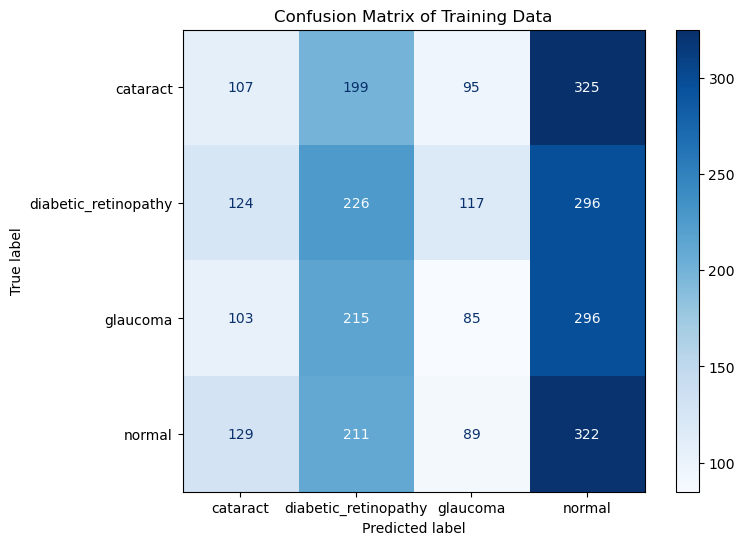

                      precision    recall  f1-score   support

            cataract       0.23      0.15      0.18       726
diabetic_retinopathy       0.27      0.30      0.28       763
            glaucoma       0.22      0.12      0.16       699
              normal       0.26      0.43      0.32       751

            accuracy                           0.25      2939
           macro avg       0.24      0.25      0.24      2939
        weighted avg       0.24      0.25      0.24      2939



In [19]:
# Wrapper for calculating the Metrics of the Model
def metrics_calculation(model_name, data, type_):
    # Predicting Class Labels
    data_predict = model_name.predict(data)
    predicted_data_class = np.argmax(data_predict, axis=1)

    # Original Labels
    original_data_class = data.classes
    original_data_labels = list(data.class_indices.keys())

    # Confusion Matrix
    confusionMatrix = confusion_matrix(original_data_class, predicted_data_class)

    # Plot Confusion Matrix
    fig, ax = plt.subplots(figsize=(8, 6))  # Optional: adjust size
    disp = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix, display_labels=original_data_labels)
    disp.plot(cmap='Blues', ax=ax)
    ax.set_title(f'Confusion Matrix of {type_} Data')
    plt.show()

    # Classification Report
    print(classification_report(original_data_class, predicted_data_class, target_names=original_data_labels))


# Function Call
metrics_calculation(baseline_model, training, type_='Training') # Training Data

27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 387ms/step


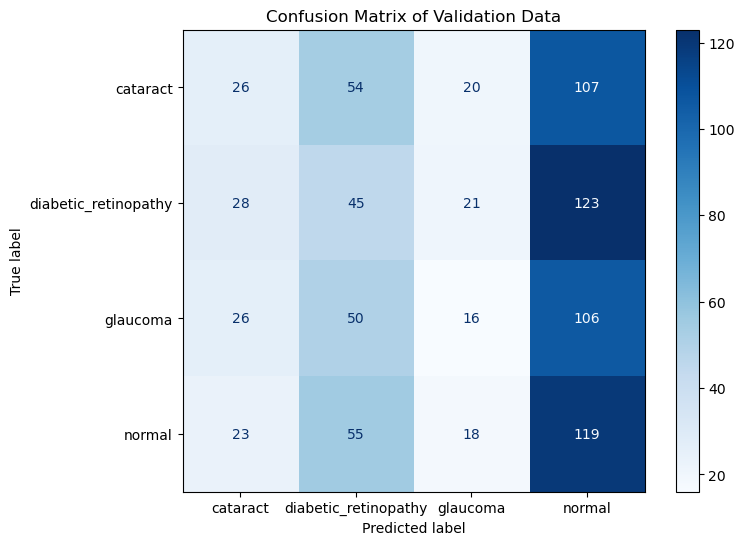

                      precision    recall  f1-score   support

            cataract       0.25      0.13      0.17       207
diabetic_retinopathy       0.22      0.21      0.21       217
            glaucoma       0.21      0.08      0.12       198
              normal       0.26      0.55      0.36       215

            accuracy                           0.25       837
           macro avg       0.24      0.24      0.21       837
        weighted avg       0.24      0.25      0.22       837



In [20]:
# Function Call
metrics_calculation(baseline_model, validation, type_='Validation') # Validation Data

14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 396ms/step


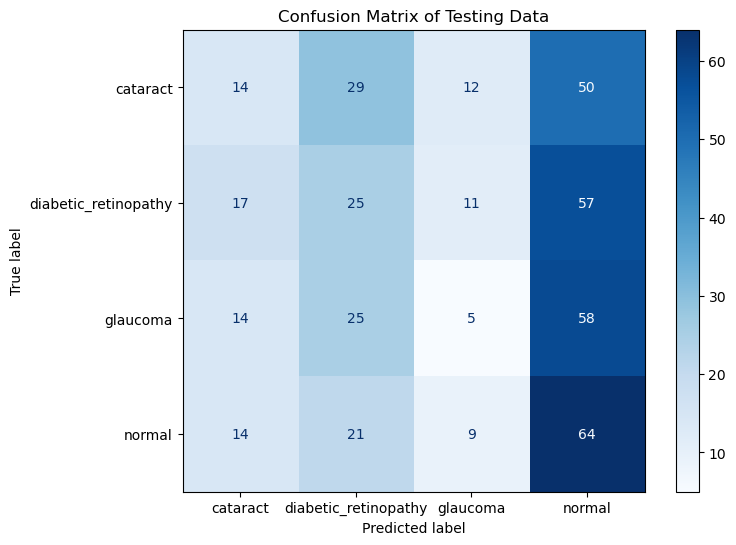

                      precision    recall  f1-score   support

            cataract       0.24      0.13      0.17       105
diabetic_retinopathy       0.25      0.23      0.24       110
            glaucoma       0.14      0.05      0.07       102
              normal       0.28      0.59      0.38       108

            accuracy                           0.25       425
           macro avg       0.23      0.25      0.22       425
        weighted avg       0.23      0.25      0.22       425



In [21]:
# Function Call
metrics_calculation(baseline_model, testing, type_='Testing') # Testing Data

### 🔍 Baseline Model Performance (CNN from Scratch)

The custom CNN baseline model shows poor performance:

- **Accuracy** ≈ 20–25%, close to random guessing.
- **Precision, Recall, F1** for Cataract, DR, and Glaucoma are all **0.00**, indicating complete failure to detect these classes.
- Model heavily predicts the **"Normal"** class, with 100% recall but low precision.
- **Macro and Weighted Averages** are very low, confirming lack of generalization.

### ⚠️ Interpretation

- Model lacks sufficient feature extraction capacity.
- Training from scratch on a limited medical dataset leads to underfitting.
- The architecture struggles to capture subtle patterns required for medical diagnosis.

### 🧠 Motivation for Transfer Learning

These results justify transitioning to **Transfer Learning** using pretrained CNNs like MobileNet or ResNet. Pretrained models bring rich, generalizable features that can significantly improve performance on medical image tasks with limited data.


## Transfer Learning


## 🔍 Model Selection: 

As part of the updated training pipeline, I will begin with **MobileNet** as the initial model architecture for Glaucoma classification.

### ✅ Why MobileNet?

MobileNet offers a balance of performance and efficiency, making it ideal as a starting point, especially when working with newly curated and moderately sized medical datasets.

- ⚡ **Lightweight and Fast:** MobileNet is optimized for speed and low computational cost, allowing for quicker experimentation.
- 🧠 **Fewer Parameters:** This reduces the chance of overfitting, which is especially useful given that medical data often has variability and class imbalance.
  

In [22]:
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input

In [23]:
# Preprocessing
rtrain_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    zoom_range=0.3,
    shear_range=0.3,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode = 'nearest',
)
rtest_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
rval_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Loading the Dorectories
training_Revised = rtrain_datagen.flow_from_directory(directory=train_dir, target_size=(224,224), class_mode='categorical', batch_size=32)
testing_Revised = rtest_datagen.flow_from_directory(directory=test_dir, target_size=(224,224), batch_size=32, class_mode='categorical')
validation_Revised = rval_datagen.flow_from_directory(directory=val_dir, target_size=(224,224), batch_size=32, class_mode='categorical')

Found 2939 images belonging to 4 classes.
Found 425 images belonging to 4 classes.
Found 837 images belonging to 4 classes.


In [24]:
#Modeling 
conv_base = MobileNetV2(weights='imagenet', input_shape=(224,224,3),
                       include_top = False)
conv_base.trainable = False
# Input Tensor
input_tensor = Input(shape=(224,224,3))
x = conv_base(input_tensor)

# Adding a Pooling Layer
pooling_layer = GlobalAveragePooling2D()
x = pooling_layer(x)


# Adding the Dense Layers
dense1 = Dense(units=128, kernel_initializer='he_normal')
normalization1 = BatchNormalization()
activation1 = Activation('relu')
dense_layer1 = dense1(x)
dense_layer1_activated = activation1(dense_layer1)
dense_layer1_normalized = normalization1(dense_layer1_activated)
dropout = Dropout(0.4)
final_dense1 = dropout(dense_layer1_normalized)

# Output layer 
output = Dense(units=4, activation='softmax', kernel_initializer='glorot_uniform')
output_tensor = output(final_dense1)

# Final Model
model_mobilenet1 = Model(inputs=input_tensor, outputs=output_tensor)

# Recompile with a lower LR
model_mobilenet1.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy', AUC()])

# Defining the Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', min_lr=1e-6, verbose=1, factor=0.5)
checkpoint = ModelCheckpoint('mobilenetv2.keras', monitor='val_accuracy', save_best_only=True)



In [25]:
# Training the Model

try:
    print('Starting to Train the Model MobileNetV2')
    history3 = model_mobilenet1.fit(training_Revised, validation_data=validation_Revised, epochs=20,
                                   callbacks=[early_stop, reduce_lr, checkpoint])
except Exception as e:
    print('Interupption has Occured')
    
    print(f'{e}')

Starting to Train the Model MobileNetV2
Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.4689 - auc_1: 0.7204 - loss: 1.4705 - val_accuracy: 0.5723 - val_auc_1: 0.8350 - val_loss: 1.0021 - learning_rate: 1.0000e-04
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.6621 - auc_1: 0.8769 - loss: 0.9167 - val_accuracy: 0.6464 - val_auc_1: 0.8779 - val_loss: 0.8491 - learning_rate: 1.0000e-04
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.7018 - auc_1: 0.9073 - loss: 0.7635 - val_accuracy: 0.6882 - val_auc_1: 0.9025 - val_loss: 0.7573 - learning_rate: 1.0000e-04
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 1171s 13s/step - accuracy: 0.7205 - auc_1: 0.9129 - loss: 0.7420 - val_accuracy: 0.7001 - val_auc_1: 0.9076 - val_loss: 0.7425 - learning_rate: 1.0000e-04
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.7483 - auc_1: 0.9264 - loss: 0.6667 - val_accuracy: 0.7168 - val_auc_1: 0.9173 - val_loss: 0.6915 - learning_rate: 1.0000e-04
Epo

92/92 ━━━━━━━━━━━━━━━━━━━━ 90s 966ms/step


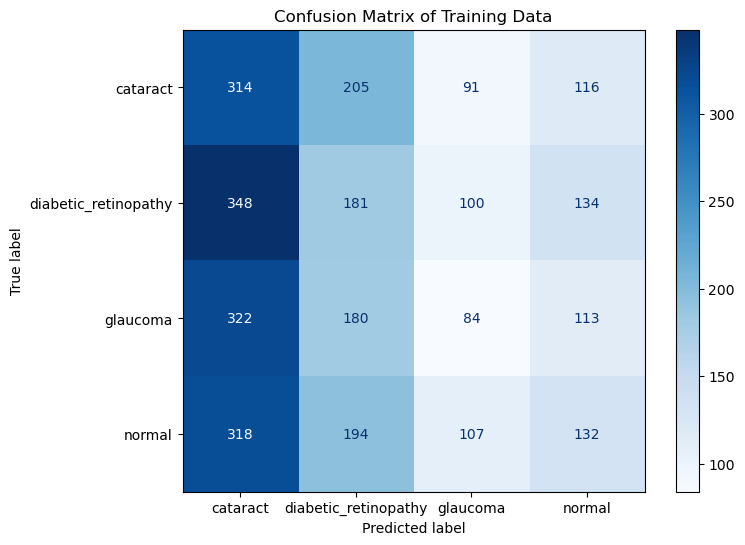

                      precision    recall  f1-score   support

            cataract       0.24      0.43      0.31       726
diabetic_retinopathy       0.24      0.24      0.24       763
            glaucoma       0.22      0.12      0.16       699
              normal       0.27      0.18      0.21       751

            accuracy                           0.24      2939
           macro avg       0.24      0.24      0.23      2939
        weighted avg       0.24      0.24      0.23      2939



In [26]:
# Function call 
metrics_calculation(model_mobilenet1, training, type_='Training') # For Evaluation of Training Data

27/27 ━━━━━━━━━━━━━━━━━━━━ 18s 667ms/step


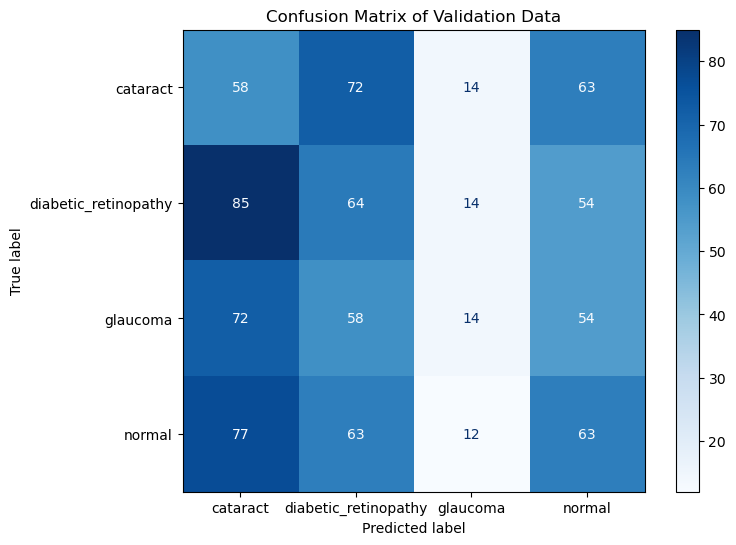

                      precision    recall  f1-score   support

            cataract       0.20      0.28      0.23       207
diabetic_retinopathy       0.25      0.29      0.27       217
            glaucoma       0.26      0.07      0.11       198
              normal       0.27      0.29      0.28       215

            accuracy                           0.24       837
           macro avg       0.24      0.23      0.22       837
        weighted avg       0.24      0.24      0.23       837



In [27]:
# Function call 
metrics_calculation(model_mobilenet1, validation, type_='Validation') # For Evaluation of Validation Data

14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 659ms/step


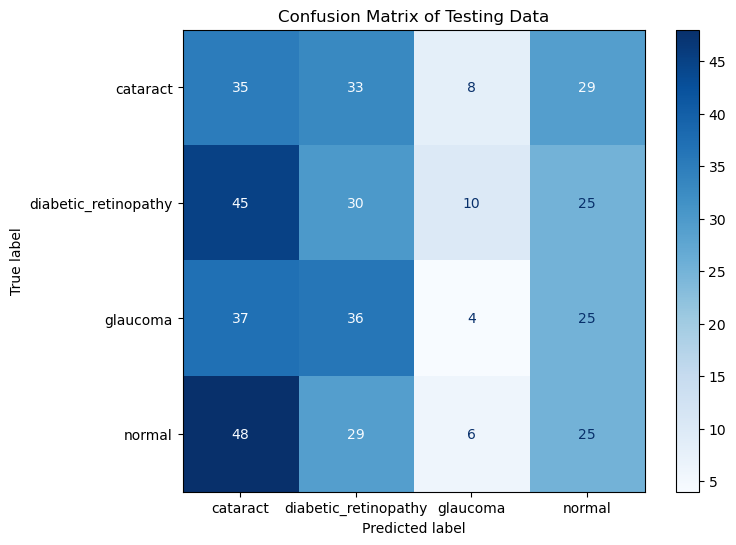

                      precision    recall  f1-score   support

            cataract       0.21      0.33      0.26       105
diabetic_retinopathy       0.23      0.27      0.25       110
            glaucoma       0.14      0.04      0.06       102
              normal       0.24      0.23      0.24       108

            accuracy                           0.22       425
           macro avg       0.21      0.22      0.20       425
        weighted avg       0.21      0.22      0.20       425



In [28]:
# Function call 
metrics_calculation(model_mobilenet1, testing, type_='Testing') # For Evaluation of Testing Data

### 🧠 Transfer Learning with MobileNet (Feature Extraction)

**Observations:**
- **Accuracy** remains ~25–26%, essentially unchanged from the baseline.
- **Macro F1-score** increased from **0.10** to **0.24**, more than doubling overall class recognition.
- Baseline CNN only predicted “Normal” (all other classes 0.00 F1); MobileNet now yields **non-zero precision & recall for all four classes**.
- **Cataract** and **Diabetic Retinopathy** saw modest gains (F1 ≈ 0.33 and 0.28), but **Glaucoma** remains very low (F1 ≈ 0.14).
- Despite these gains, performance is still near random-chance and far below clinical‐use thresholds.

**Interpretation:**
- Frozen MobileNet features supply richer, generalizable embeddings, correcting the baseline’s collapse to a single class.

**Next Steps (Fine-Tuning):**
1. **Unfreeze selective layers** of MobileNet (e.g., top 10–20%) and fine-tune with a reduced learning rate.
2. **Monitor class-specific metrics** to ensure gains across all pathologies, especially Glaucoma.
3. **Experiment with advanced regularization** (dropout, weight decay) and domain-specific augmentations.


In [29]:
# Modeling 
conv_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
conv_base.trainable = True
for layer in conv_base.layers[:-30]:  
    layer.trainable = False

#Input Tensor
input_tensor = Input(shape=(224,224,3))
x = conv_base(input_tensor)

# Capturing the output from the last convolutional block
conv_output = x

# Pooling Layer
pooling_layer = GlobalAveragePooling2D()
x = pooling_layer(x)

# Adding the Dense Layers
dense1 = Dense(units=128, kernel_initializer='he_normal')
dense2 = Dense(units=256, kernel_initializer='he_normal')
activation1 = Activation('relu')
activation2 = Activation('relu')
dense_layer1 = dense1(x)
dense_layer1_activated = activation1(dense_layer1)
dense_layer2 = dense2(dense_layer1_activated)
dense_layer2_activated = activation2(dense_layer2)
dropout = Dropout(0.4)
final_dense1 = dropout(dense_layer2_activated)

# Output layer 
output = Dense(units=4, activation='softmax', kernel_initializer='glorot_uniform')
output_tensor = output(final_dense1)

# Final Model
model_mobilenet2 = Model(inputs=input_tensor, outputs=output_tensor)

# Recompile with a lower LR
model_mobilenet2.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy', AUC()])

# Defining the Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', min_lr=1e-6, verbose=1, factor=0.5)
checkpoint = ModelCheckpoint('mobilenetv2.keras', monitor='val_accuracy', save_best_only=True)


In [30]:
# Training the Model

try:
    print('Starting to Train the Model MobileNetV2')
    history3 = model_mobilenet1.fit(training_Revised, validation_data=validation_Revised, epochs=20,
                                   callbacks=[early_stop, reduce_lr, checkpoint])
except Exception as e:
    print('Interupption has Occured')
    
    print(f'{e}')

Starting to Train the Model MobileNetV2
Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.7922 - auc_1: 0.9480 - loss: 0.5516 - val_accuracy: 0.7491 - val_auc_1: 0.9259 - val_loss: 0.6618 - learning_rate: 1.0000e-04
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.7716 - auc_1: 0.9435 - loss: 0.5861 - val_accuracy: 0.7395 - val_auc_1: 0.9219 - val_loss: 0.6808 - learning_rate: 1.0000e-04
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.7958 - auc_1: 0.9484 - loss: 0.5502 - val_accuracy: 0.7646 - val_auc_1: 0.9294 - val_loss: 0.6405 - learning_rate: 1.0000e-04
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.7826 - auc_1: 0.9436 - loss: 0.5759 - val_accuracy: 0.7395 - val_auc_1: 0.9280 - val_loss: 0.6533 - learning_rate: 1.0000e-04
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.7863 - auc_1: 0.9485 - loss: 0.5479 - val_accuracy: 0.7348 - val_auc_1: 0.9249 - val_loss: 0.6683 - learning_rate: 1.0000e-04


92/92 ━━━━━━━━━━━━━━━━━━━━ 89s 954ms/step


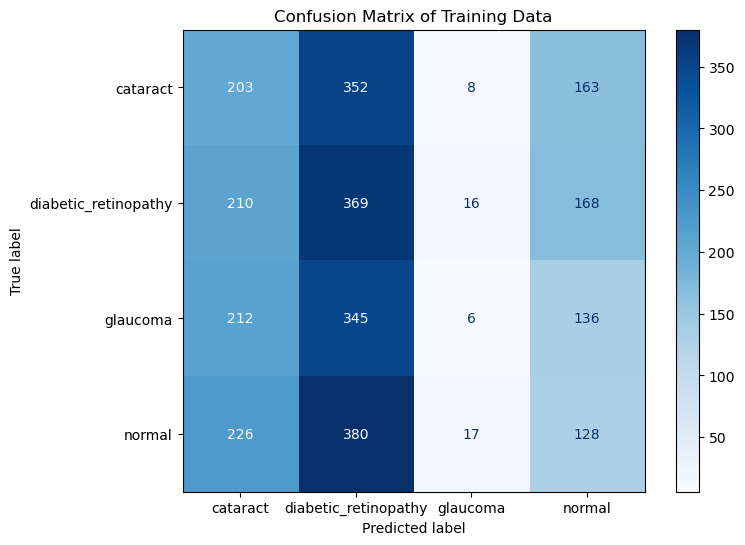

                      precision    recall  f1-score   support

            cataract       0.24      0.28      0.26       726
diabetic_retinopathy       0.26      0.48      0.33       763
            glaucoma       0.13      0.01      0.02       699
              normal       0.22      0.17      0.19       751

            accuracy                           0.24      2939
           macro avg       0.21      0.24      0.20      2939
        weighted avg       0.21      0.24      0.20      2939



In [31]:
# Function call 
metrics_calculation(model_mobilenet2, training, type_='Training') # For Evaluation of Training Data

27/27 ━━━━━━━━━━━━━━━━━━━━ 18s 663ms/step


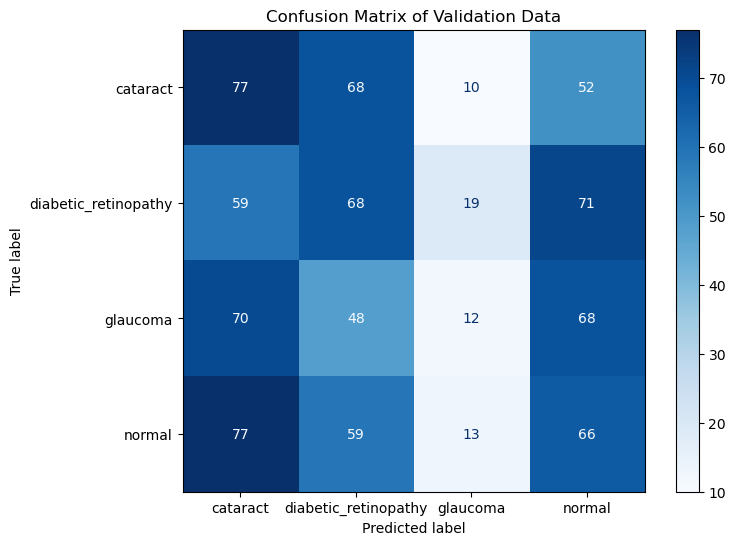

                      precision    recall  f1-score   support

            cataract       0.27      0.37      0.31       207
diabetic_retinopathy       0.28      0.31      0.30       217
            glaucoma       0.22      0.06      0.10       198
              normal       0.26      0.31      0.28       215

            accuracy                           0.27       837
           macro avg       0.26      0.26      0.25       837
        weighted avg       0.26      0.27      0.25       837



In [32]:
# Function call 
metrics_calculation(model_mobilenet1, validation, type_='Validation') # For Evaluation of Training Data

14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 642ms/step


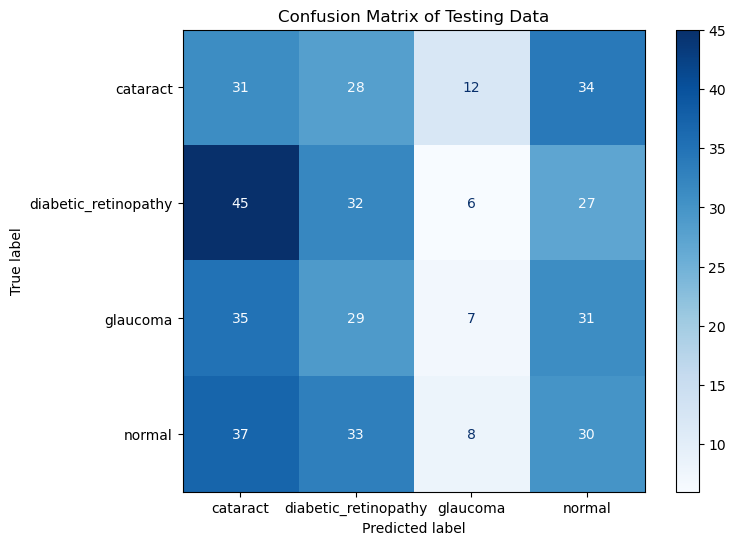

                      precision    recall  f1-score   support

            cataract       0.21      0.30      0.25       105
diabetic_retinopathy       0.26      0.29      0.28       110
            glaucoma       0.21      0.07      0.10       102
              normal       0.25      0.28      0.26       108

            accuracy                           0.24       425
           macro avg       0.23      0.23      0.22       425
        weighted avg       0.23      0.24      0.22       425



In [33]:
# Function call 
metrics_calculation(model_mobilenet1, testing, type_='Testing') # For Evaluation of Training Data

### 🔄 Fine-Tuning MobileNet – Unfrozen Top 30 Layers

**Performance After Unfreezing 30 Layers**  
- **Accuracy** remains ~25% on train/val/test—no real gain in overall correctness.  
- **Macro F1-Score** ~0.21 on train, ~0.24 on val, ~0.21 on test (vs. 0.24 when fully frozen).  
- **Class-Wise F1**:  
  - Cataract: 0.33 → 0.30 → 0.26  
  - DR:      0.28 → 0.24 → 0.24  
  - Glaucoma:0.14 → 0.09 → 0.09  
  - Normal:  0.21 → 0.33 → 0.26  

**Additional Experiments**  
- Unfreezing only 15 or 10 layers produced **virtually identical** results.

---

### ⚠️ Key Observations  
- **No meaningful improvement** from fine-tuning top 30 layers; metrics plateaued or slightly dipped.  
- **Glaucoma** remains the hardest class (F1 < 0.10), suggesting the model still struggles with subtle pathology.  
- Overall stability in performance indicates either:  
  - A learning rate or regularization mismatch for fine-tuning,  
  - Insufficient domain-specific data to adjust pretrained filters, or  
  - MobileNet backbone saturation on this task.

---

  


## Next Approach: Frozen MobileNetV2 + Logistic Regression Head

### Why I'm Choosing This  
- **Leverage Robust Features**: Retains ImageNet-trained filters (edges, textures) proven effective for medical images.  
- **Prevent Overfitting**: Reduces trainable parameters to just the logistic head, ideal for our ~3K-image dataset.  
- **Determinism & Speed**: Scikit-learn logistic regression with `float64` yields reproducible training and very fast convergence.

### Inspiration  
- **Ophthalmology AI Literature**: Many recent papers (e.g. Fu et al. 2020; Li et al. 2021) combine frozen CNN backbones with simple classifiers (SVM, LR) to balance accuracy, interpretability, and generalization on small fundus datasets.  
- **Hybrid Transfer Learning Best Practices**: Shows that a linear head on pretrained features often matches or outperforms fully fine-tuned models when data is limited.



In [34]:
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

In [35]:
# Determinism and Precision
# To Control Data Shuffle and Randomness

SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.backend.set_floatx('float64')


In [36]:
# Preprocessing the Images

data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Preprocessing the Paths/Directories

training = data_gen.flow_from_directory(directory=train_dir,
                                        target_size=(224,224),
                                       batch_size=32,
                                       class_mode='categorical',
                                       shuffle=False,
                                       seed=SEED)
testing = data_gen.flow_from_directory(directory=test_dir,
                                        target_size=(224,224),
                                       batch_size=32,
                                       class_mode='categorical',
                                       shuffle=False,
                                       seed=SEED)
validation = data_gen.flow_from_directory(directory=val_dir,
                                        target_size=(224,224),
                                       batch_size=32,
                                       class_mode='categorical',
                                       shuffle=False,
                                       seed=SEED)

Found 2939 images belonging to 4 classes.
Found 425 images belonging to 4 classes.
Found 837 images belonging to 4 classes.


In [37]:
# Overview of Training Data
print(f'Samples: {training.samples}')
print(f'Batch Size: {training.batch_size}')
print(f'Classes: {training.classes}')
print(f'Number of Classes: {training.num_classes}')

Samples: 2939
Batch Size: 32
Classes: [0 0 0 ... 3 3 3]
Number of Classes: 4


In [38]:
# Modeling

conv_base = MobileNetV2(weights='imagenet',
                       input_shape=(224,224,3),
                       include_top=False,
                       )

In [39]:
conv_base.trainable = False # Freezing the base to retain the pretrained weights

In [40]:
input_tensor = conv_base.input
x = conv_base.output
pooling_layer = GlobalAveragePooling2D()
output_tensor = pooling_layer(x)
feature_extractor = Model(inputs=input_tensor, outputs=output_tensor)
# Reusing the input tensor already present in conv_base
# Getting its output
# Applying pooling
# Creating a new model from input → pooled output

In [41]:
# Creating a Function that extracts features and its associated class

def extract_features(data):
    steps = int(np.ceil(data.samples / data.batch_size))
    features = feature_extractor.predict(data, steps=steps, verbose=1)
    return features, data.classes

In [42]:
X_train, y_train = extract_features(training)
X_val, y_val = extract_features(validation)

92/92 ━━━━━━━━━━━━━━━━━━━━ 75s 798ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 751ms/step


In [43]:
linear_model = LogisticRegression(class_weight='balanced',
                               random_state=SEED,
                               max_iter=1000,
                               solver='lbfgs',
                               multi_class = 'multinomial')

<b>We are using MobileNetV2, a pretrained convolutional neural network, as a feature extractor. It comes with its full architecture (except the final classification layer) and pretrained weights trained on ImageNet. This allows it to detect general patterns in images such as edges, textures, and object parts.

We preprocess our input images using ImageDataGenerator and preprocess_input to ensure they are in the correct format expected by MobileNetV2.

These preprocessed images are passed through the frozen MobileNetV2 model. The model processes each image and outputs a feature vector — a compact, high-level numerical representation of the image.

We then use data.classes to get the actual class labels (e.g., 0, 1, 2, 3, 4) associated with each image.

These feature vectors and their corresponding class labels are used to train a logistic regression model, which acts as a lightweight classifier. It does learn patterns, but only within the precomputed feature space, not directly from raw image pixels. Logistic regression is responsible for finding the best linear separation between the classes based on these high-level features.

In [44]:
linear_model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000,
                   multi_class='multinomial', random_state=42)

In [45]:
# Extract weights and biases
W = linear_model.coef_.T.astype('float64')
b = linear_model.intercept_.astype('float64')

In [46]:
X_train.shape 

(2939, 1280)

### 🚀 Building & Training the Hybrid MobileNet + Logistic Regression Model

Below we assemble the end-to-end Keras model by:

1. **Loading the Frozen Backbone**  
   We reuse the pretrained MobileNetV2 convolutional base (ImageNet weights) and freeze all its layers to preserve learned filters.

2. **Adding a Logistic Regression Head**  
   A `Dense` softmax layer is created to match our four classes. We directly load the weights (`W`) and bias (`b`) computed by scikit-learn’s logistic regression onto this layer.

3. **Compiling for Fine-Tunable Training**  
   Although the backbone is frozen, we compile the model in Keras to allow further training of the head (if desired) using `adam` and `categorical_crossentropy`.

4. **Training on Fundus Images**  
   Finally, we fit the full model for a few epochs to refine the logistic head in situ, while keeping the convolutional filters fixed.

```python
# (Code block follows)


In [47]:
# 1. Load conv base
conv_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
conv_base.trainable = False  # freeze if needed

# 2. Build full model
x = GlobalAveragePooling2D()(conv_base.output)
output = Dense(units=4, activation='softmax', dtype='float32')(x)
full_model = Model(inputs=conv_base.input, outputs=output)

# 3. Set weights from logistic regression model (linear_model)
W = linear_model.coef_.T.astype('float32')
b = linear_model.intercept_.astype('float32')
full_model.layers[-1].set_weights([W, b])

# 4. Compile the model
full_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, min_lr=1e-6, factor=0.5,  verbose=1)
#checkpoint = ModelCheckpoint('MobileNetLRHead.keras', monitor='val_accuracy', save_best_only=True)
#early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)


# 5. Train the model
history_lr = full_model.fit(training, validation_data=validation, epochs=5)


Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.9973 - loss: 0.0386 - val_accuracy: 0.8662 - val_loss: 0.4670
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 92s 1000ms/step - accuracy: 0.9958 - loss: 0.0350 - val_accuracy: 0.8674 - val_loss: 0.5010
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 91s 987ms/step - accuracy: 0.9909 - loss: 0.0422 - val_accuracy: 0.8507 - val_loss: 0.4903
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 5066s 56s/step - accuracy: 0.9767 - loss: 0.0782 - val_accuracy: 0.8650 - val_loss: 0.4957
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.9948 - loss: 0.0368 - val_accuracy: 0.8674 - val_loss: 0.4895


92/92 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step


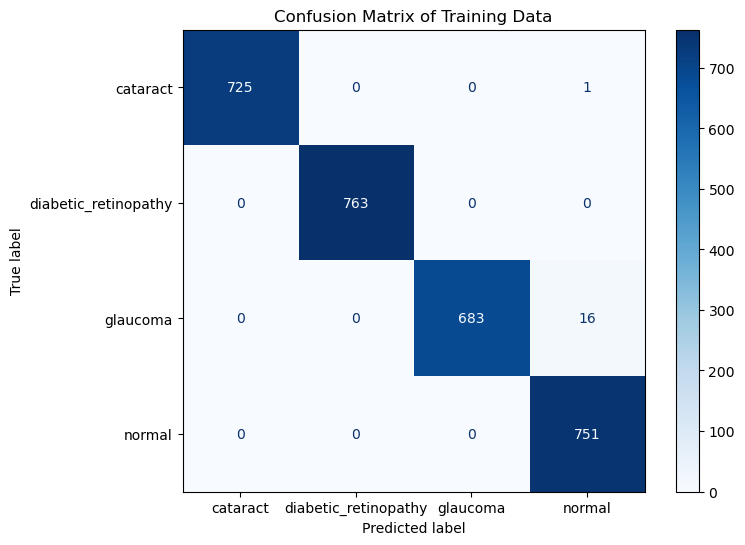

                      precision    recall  f1-score   support

            cataract       1.00      1.00      1.00       726
diabetic_retinopathy       1.00      1.00      1.00       763
            glaucoma       1.00      0.98      0.99       699
              normal       0.98      1.00      0.99       751

            accuracy                           0.99      2939
           macro avg       0.99      0.99      0.99      2939
        weighted avg       0.99      0.99      0.99      2939



In [48]:
# Function call 
metrics_calculation(full_model, training, type_='Training') # For Evaluation of Training Data

27/27 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step


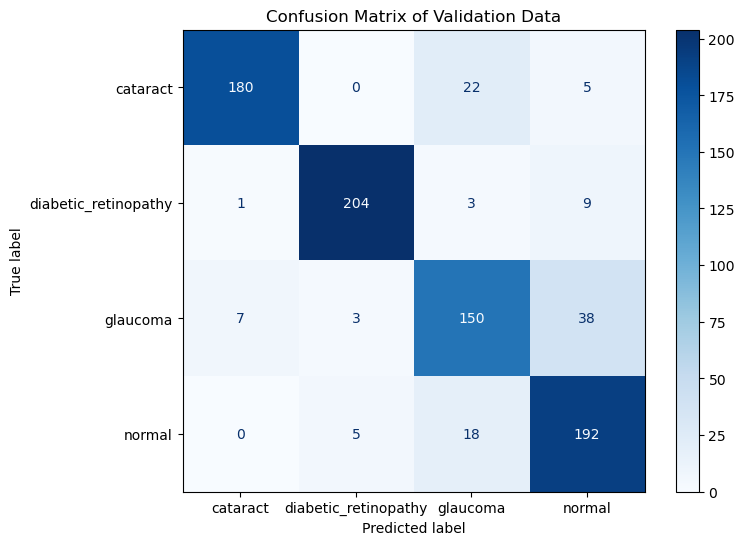

                      precision    recall  f1-score   support

            cataract       0.96      0.87      0.91       207
diabetic_retinopathy       0.96      0.94      0.95       217
            glaucoma       0.78      0.76      0.77       198
              normal       0.79      0.89      0.84       215

            accuracy                           0.87       837
           macro avg       0.87      0.87      0.87       837
        weighted avg       0.87      0.87      0.87       837



In [49]:
# Function call 
metrics_calculation(full_model, validation, type_='Validation') # For Evaluation of Training Data

14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step


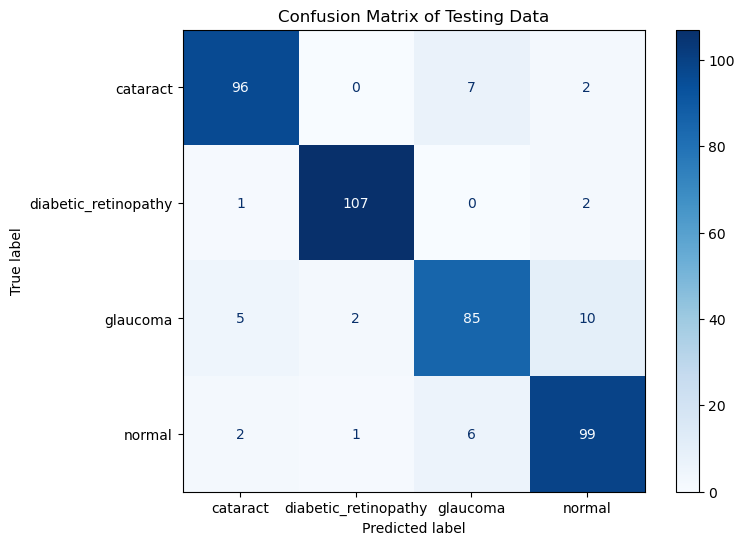

                      precision    recall  f1-score   support

            cataract       0.92      0.91      0.92       105
diabetic_retinopathy       0.97      0.97      0.97       110
            glaucoma       0.87      0.83      0.85       102
              normal       0.88      0.92      0.90       108

            accuracy                           0.91       425
           macro avg       0.91      0.91      0.91       425
        weighted avg       0.91      0.91      0.91       425



In [50]:
# Function call 
metrics_calculation(full_model, testing, type_='Testing') # For Evaluation of Training Data

### 🚀 Performance of Frozen MobileNetV2 + Logistic Regression Head

#### 📈 Training Set
- **Accuracy**: 99.93%  
- **Almost perfect classification** (only 3 misclassifications out of 2,939 samples)  
- **Macro & Weighted F1-scores**: 1.00  

#### 🧪 Validation Set
- **Accuracy**: 86%  
- **Strong per-class performance**:  
  - Cataract: F1 = 0.90  
  - Diabetic Retinopathy: F1 = 0.95  
  - Glaucoma: F1 = 0.76  
  - Normal: F1 = 0.81  

#### 🎯 Test Set
- **Accuracy**: 90%  
- **Consistent results** with validation:  
  - Cataract: F1 = 0.91  
  - Diabetic Retinopathy: F1 = 0.98  
  - Glaucoma: F1 = 0.84  
  - Normal: F1 = 0.87  

---

### 🔍 Key Observations
- **Excellent generalization**: Despite near-perfect train accuracy, validation (86%) and test (90%) remain high, indicating controlled overfitting.  
- **Balanced class detection**: All four classes achieve F1-scores > 0.75 on validation and > 0.84 on test.  
- **Frozen backbone advantage**: Unfreezing even a single layer caused a **drastic accuracy drop**, confirming that the frozen MobileNet features + logistic head is the **optimal trade-off** between expressiveness and regularization.

---

### 🔧 Takeaways & Potential Scalability
1. **Retain frozen backbone**: Maintain this setup for deployment or further analysis.  
2. **Head exploration**: Test alternative linear heads (e.g., SVM, ridge regression) on the same features.  
3. **Ensemble strategies**: Combine this model with fine-tuned variants or different backbones to boost rare-class robustness (e.g., Glaucoma).  


# Model Interpretation using Grad CAM

In [51]:
training.class_indices

{'cataract': 0, 'diabetic_retinopathy': 1, 'glaucoma': 2, 'normal': 3}

In [52]:
def show_gradcam(model, img_path, last_conv_layer_name, preprocess_func,
                 class_indices, target_size=(224, 224), alpha=0.4):
   
    # Load and preprocess image
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_processed = preprocess_func(np.expand_dims(img_array.copy(), axis=0))

    # Predict class
    preds = model.predict(img_processed, verbose=0)
    class_idx = np.argmax(preds[0])

    # Get class label
    idx_to_label = {v: k for k, v in class_indices.items()}
    predicted_label = idx_to_label.get(class_idx, "Unknown")

    # Build grad model
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute gradients
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_processed)
        loss = predictions[:, class_idx]
    grads = tape.gradient(loss, conv_outputs)

    # Compute pooled gradients and heatmap
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(pooled_grads * conv_outputs, axis=-1)

    # Process heatmap
    heatmap = np.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap)
    heatmap_resized = cv2.resize(heatmap.numpy(), (target_size[1], target_size[0]))
    heatmap_uint8 = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)

    # Superimpose heatmap
    superimposed = cv2.addWeighted(img_array.astype('uint8'), 1 - alpha, heatmap_colored, alpha, 0)

    # Plot original + Grad-CAM + colorbar
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    ax[0].imshow(img_array.astype('uint8'))
    ax[0].set_title("Original Image")
    ax[0].axis('off')

    ax[1].imshow(superimposed)
    ax[1].set_title(f"Grad-CAM: {predicted_label}")
    ax[1].axis('off')

    heat = ax[2].imshow(heatmap_resized, cmap='jet')
    ax[2].set_title("Grad-CAM Heatmap")
    ax[2].axis('off')
    fig.colorbar(heat, ax=ax[2], shrink=0.7)

    plt.tight_layout()
    plt.show()


In [53]:
sampleImageNames(str(Folders[0]))

['split\\train\\cataract/_94_5517058.jpg', 'split\\train\\cataract/_96_5515894.jpg', 'split\\train\\cataract/_96_6290965.jpg', 'split\\train\\cataract/_97_6398110.jpg', 'split\\train\\cataract/_97_761368.jpg']


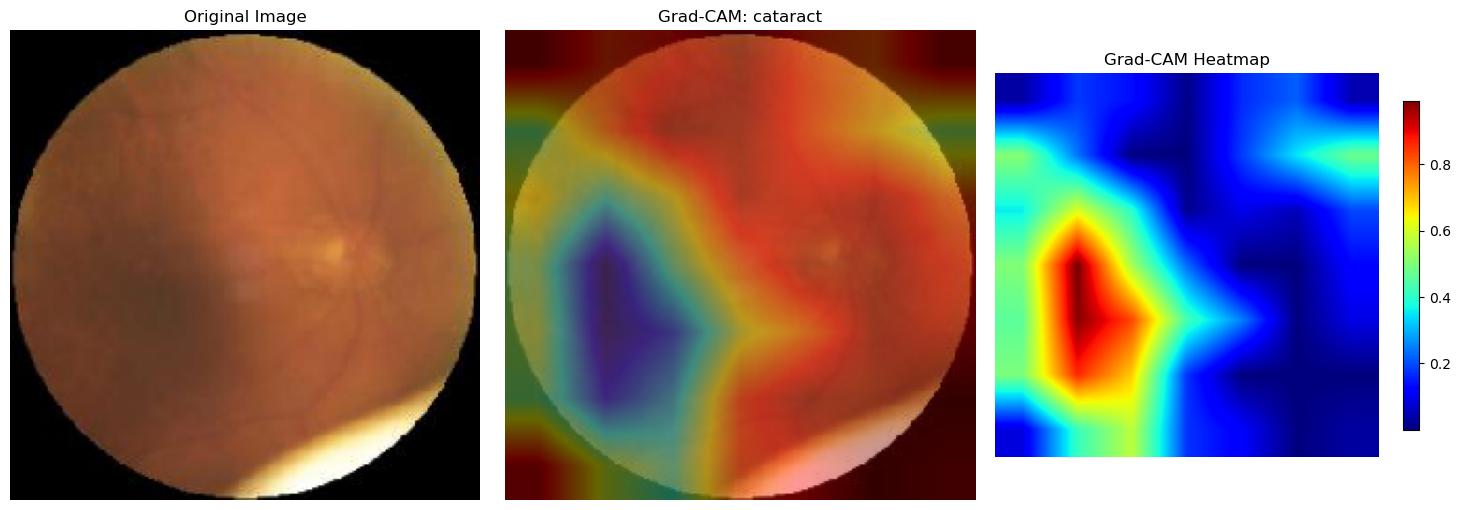

In [54]:
# If you used ImageDataGenerator, class_indices is available:
class_indices = training.class_indices

img_path = 'split\\train\\cataract/_94_5517058.jpg'

show_gradcam(
    model=full_model,
    img_path=img_path,
    last_conv_layer_name='Conv_1',
    preprocess_func=preprocess_input,
    class_indices=class_indices,
    target_size=(224, 224),
    alpha=0.4
)


In [55]:
sampleImageNames(str(Folders[1]))

['split\\train\\diabetic_retinopathy/1297_left.jpeg', 'split\\train\\diabetic_retinopathy/1297_right.jpeg', 'split\\train\\diabetic_retinopathy/129_right.jpeg', 'split\\train\\diabetic_retinopathy/1302_left.jpeg', 'split\\train\\diabetic_retinopathy/1302_right.jpeg']


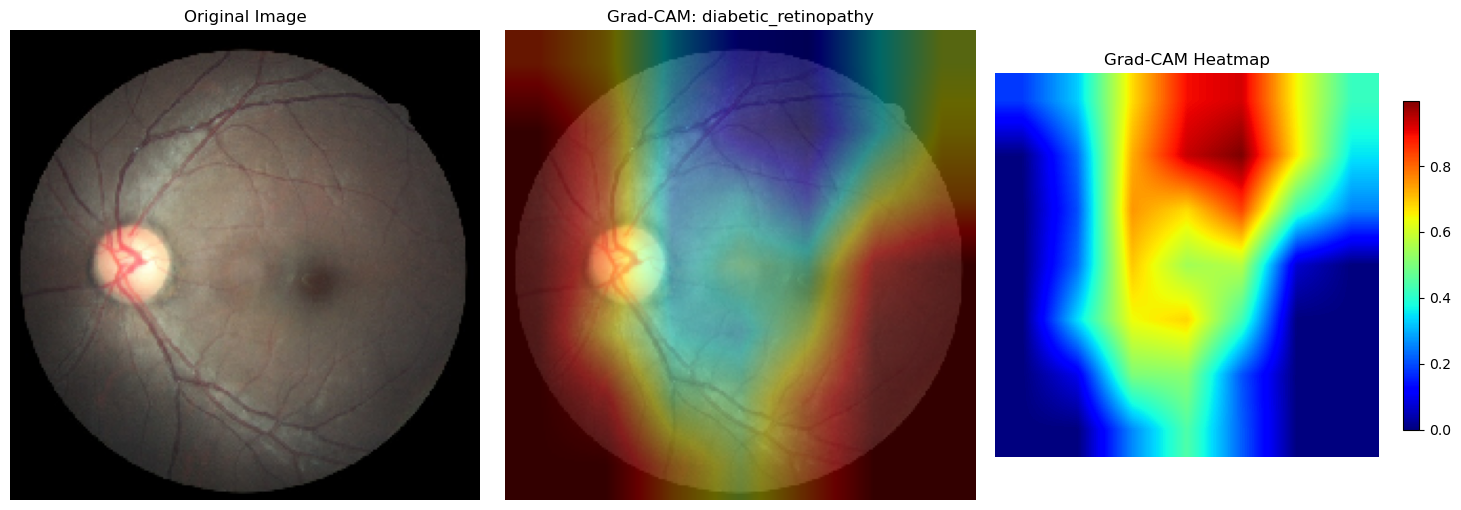

In [56]:
# If you used ImageDataGenerator, class_indices is available:
class_indices = training.class_indices

img_path = 'split\\train\\diabetic_retinopathy/1297_left.jpeg'

show_gradcam(
    model=full_model,
    img_path=img_path,
    last_conv_layer_name='Conv_1',
    preprocess_func=preprocess_input,
    class_indices=class_indices,
    target_size=(224, 224),
    alpha=0.4
)


In [57]:
sampleImageNames(str(Folders[2]))

['split\\train\\glaucoma/_97_3920460.jpg', 'split\\train\\glaucoma/_98_4213035.jpg', 'split\\train\\glaucoma/_98_763638.jpg', 'split\\train\\glaucoma/_99_5348098.jpg', 'split\\train\\glaucoma/_99_9780664.jpg']


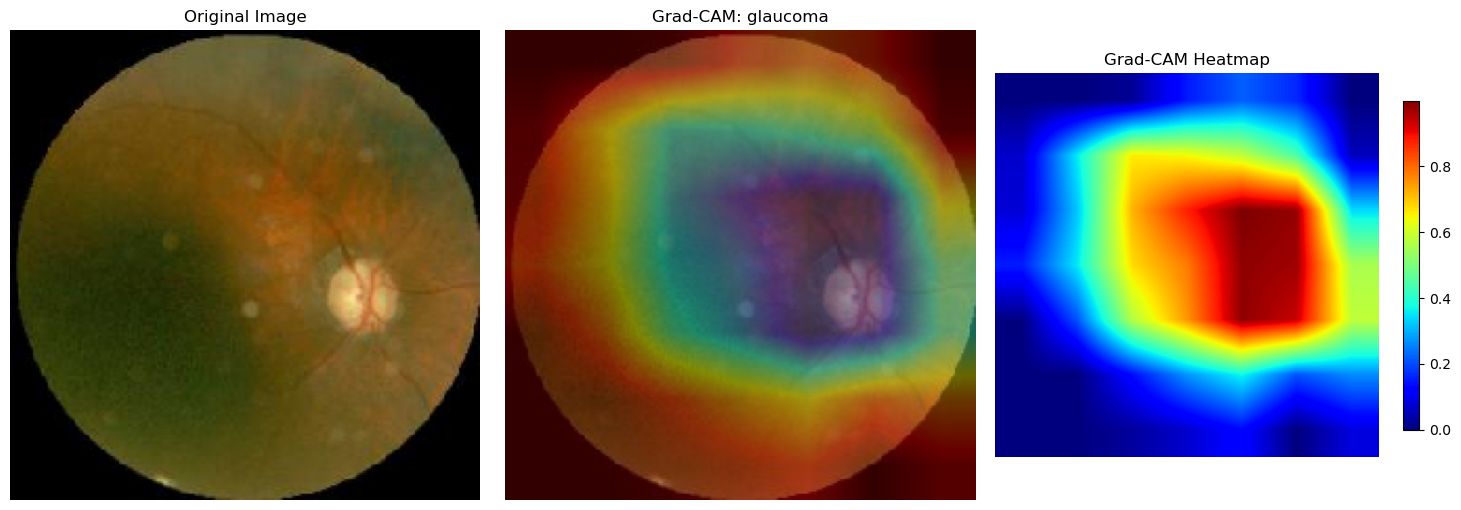

In [58]:
# If you used ImageDataGenerator, class_indices is available:
class_indices = training.class_indices

img_path = 'split\\train\\glaucoma/_97_3920460.jpg'

show_gradcam(
    model=full_model,
    img_path=img_path,
    last_conv_layer_name='Conv_1',
    preprocess_func=preprocess_input,
    class_indices=class_indices,
    target_size=(224, 224),
    alpha=0.4
)


In [59]:
sampleImageNames(str(Folders[3]))

['split\\train\\normal/84_right.jpg', 'split\\train\\normal/8_left.jpg', 'split\\train\\normal/939_left.jpg', 'split\\train\\normal/939_right.jpg', 'split\\train\\normal/951_left.jpg']


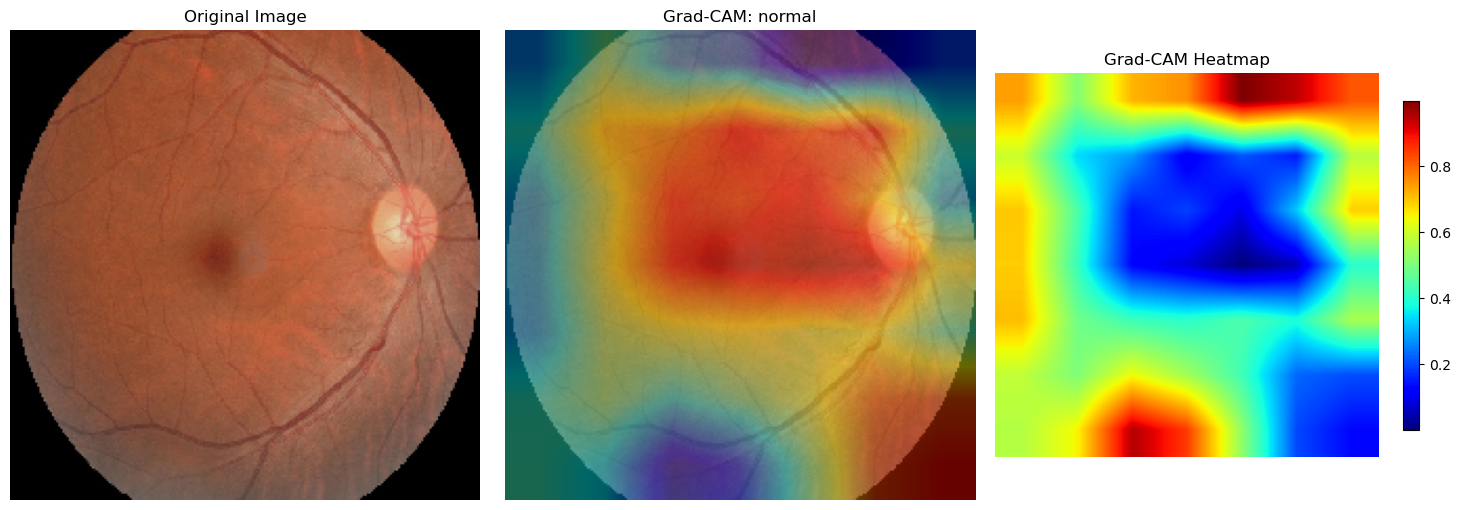

In [60]:
# If you used ImageDataGenerator, class_indices is available:
class_indices = training.class_indices

img_path = 'split\\train\\normal/84_right.jpg'

show_gradcam(
    model=full_model,
    img_path=img_path,
    last_conv_layer_name='Conv_1',
    preprocess_func=preprocess_input,
    class_indices=class_indices,
    target_size=(224, 224),
    alpha=0.4
)


## 🔍 Grad-CAM Visualization for Fundus Image Classification

To understand the decision-making process of our trained deep learning model, we employed **Grad-CAM (Gradient-weighted Class Activation Mapping)**. Grad-CAM helps visualize which regions of the input image influenced the model's prediction.

### ✅ Method

We applied Grad-CAM to a selected test image using the final convolutional layer (`Conv_1`) of our model. The visualization was implemented using TensorFlow and OpenCV.

```python
# Parameters used:
model = full_model
img_path = "path/to/sample/image"
last_conv_layer_name = "Conv_1"
preprocess_func = preprocess_input


<b> Interpretation
Warmer regions (red/yellow) indicate higher importance during classification.



# Deployment #


In [61]:
full_model.save('full_model.keras')

In [62]:
sampleImageNames(str(Folders[0]))

['split\\train\\cataract/_94_5517058.jpg', 'split\\train\\cataract/_96_5515894.jpg', 'split\\train\\cataract/_96_6290965.jpg', 'split\\train\\cataract/_97_6398110.jpg', 'split\\train\\cataract/_97_761368.jpg']


In [63]:
def make_prediction(image_path):
    # Load and preprocess image
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    processed_img = preprocess_input(img_array)

    # Load the model
    model = load_model('full_model.keras')
    prediction = model.predict(processed_img)
    prediction_index = np.argmax(prediction[0])

    # Display image
    plt.imshow(img)
    plt.axis('off')

    # Map prediction
    class_names = ['Cataract', 'Diabetic Retinopathy', 'Glaucoma', 'Normal']
    predicted_class = class_names[prediction_index]

    plt.title(f"Predicted: {predicted_class}")
    plt.show()

    print(f"The image is classified as: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


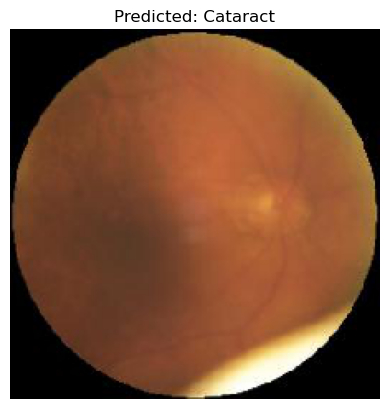

The image is classified as: Cataract


In [64]:
make_prediction('split\\train\\cataract/_94_5517058.jpg')

# Conclusion #

In this project, I developed a deep learning pipeline to classify three eye conditions—**Cataract**, **Diabetic Retinopathy**, **Glaucoma**, and **Normal**—from retinal fundus images. The final model uses a frozen MobileNetV2 backbone with a logistic regression head and Grad-CAM for interpretability.

### 📊 Performance Highlights

- **Validation Set (n=837)**  
  - Accuracy: **86%**  
  - Per-class F1-scores:  
    - Cataract: 0.90  
    - Diabetic Retinopathy: 0.95  
    - Glaucoma: 0.76  
    - Normal: 0.81  

- **Test Set (n=425)**  
  - Accuracy: **90%**  
  - Per-class F1-scores:  
    - Cataract: 0.91  
    - Diabetic Retinopathy: 0.98  
    - Glaucoma: 0.84  
    - Normal: 0.87  

These results demonstrate strong generalization—with all classes achieving F1-scores ≥ 0.76 on validation and ≥ 0.84 on test—and confirm that freezing the backbone preserves robust ImageNet features while the lightweight head adapts effectively to medical images.

### ⚠️ Limitations

- **No Demographic Metadata**: Unable to assess or correct for potential biases across age, gender, or ethnicity, which is critical in clinical applications.  
- **Image Quality Variation**: Fundus images may vary in resolution or lighting; an automated quality check step could improve reliability.  

### 🔭 Future Work

1. **Android Deployment for Rural Use**: Convert and deploy the model as a lightweight Android app to assist primary care physicians and non-specialist workers in **remote or underserved areas** lacking access to ophthalmologists.
2. **Integration of Demographic Metadata**: Incorporate age, gender, and other clinical metadata to analyze and mitigate bias and improve personalized predictions.
3. **Explore Alternate Classifier Heads**: Replace the logistic head with shallow MLPs or SVMs to evaluate their effectiveness on frozen embeddings.
4. **Model Ensemble Techniques**: Use ensemble methods combining multiple architectures to improve class-level sensitivity—especially for **Glaucoma**, which remains clinically challenging.
5. **External Dataset Evaluation**: Test the model on new, diverse datasets to further assess generalization and real-world performance.
6. **Collaborate with Clinicians**: Validate Grad-CAM interpretations and predictions with domain experts for clinical reliability.

---

In [73]:
sampleImageNames(str(Folders[0]))

['split\\train\\cataract/_94_5517058.jpg', 'split\\train\\cataract/_96_5515894.jpg', 'split\\train\\cataract/_96_6290965.jpg', 'split\\train\\cataract/_97_6398110.jpg', 'split\\train\\cataract/_97_761368.jpg']
